In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torchvision.datasets as datasets
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader

import seaborn as sns

import sys
sys.path.append('./python_files/')
import pickle

from model_trainer import ModelTrainer
from utils import *
from data_loader import *
from nn_modules import View
from nn_models import *

In [2]:
print("pytorch version: ",torch.__version__)

pytorch version:  0.5.0a0


In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print("Using GPU: ",torch.cuda.get_device_name(0))

Using GPU:  GeForce GTX 1080 Ti


## 0) Loading the data (MNIST or CIFAR-10)

In [4]:
train_input_full, train_target_full, test_input_full, test_target_full = load_data(cifar=False, normalize=True, flatten=False, full=True)

train_target_full = train_target_full.long()
test_target_full = test_target_full.long()

* Using MNIST
** Use 60000 train and 10000 test samples


In [5]:
print("shape of training samples :", train_input_full.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])


In [6]:
nb_sample = 60000
train_input = train_input_full[0:nb_sample]
train_target = train_target_full[0:nb_sample]

test_input = test_input_full[0:nb_sample]
test_target = test_target_full[0:nb_sample]

In [7]:
print("shape of training samples :", train_input.shape)
print("shape of testing samples :", test_input.shape)

shape of training samples : torch.Size([60000, 1, 28, 28])
shape of testing samples : torch.Size([10000, 1, 28, 28])


In [8]:
computeClassesWeights(train_target)

tensor([0.0987, 0.1124, 0.0993, 0.1022, 0.0974, 0.0904, 0.0986, 0.1044, 0.0975,
        0.0992])

In [9]:
computeClassesWeights(test_target)

tensor([0.0980, 0.1135, 0.1032, 0.1010, 0.0982, 0.0892, 0.0958, 0.1028, 0.0974,
        0.1009])

## 1) LeNet with disjoint trainset and testset (train 10 shadow models)

In [10]:
train_dataset = (train_input, train_target)
test_dataset = (test_input, test_target)

In [11]:
crossEntropyClassesWeigths = computeClassesWeights(train_target)

In [12]:
load_from_memory = True

In [ ]:
if not load_from_memory:
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)

    for i in range(nb_shadow_models):
        print("training model", i)
        shadow_models.append(LeoNet())

        crit_fun = lambda input_, target : (input_, target)
        y_hat_fun = lambda y: y.argmax(1)

        loss_fun = nn.CrossEntropyLoss()
        learning_rate = 0.1

        mt = ModelTrainer(shadow_models[i], loss_fun, optim.SGD(shadow_models[i].parameters(), lr=learning_rate), y_hat_fun, crit_fun)
        hist = mt.fit(shadow_train_datasets[i], shadow_test_datasets[i], epochs=300, batch_size=500, verbose=0)
        #mt.plot_training("Learning curves")

training model 0
training model 1
training model 2
training model 3
training model 4
training model 5
training model 6
training model 7
training model 8
training model 9
training model 10
training model 11
training model 12
training model 13
training model 14
training model 15
training model 16
training model 17
training model 18
training model 19
training model 20
training model 21
training model 22
training model 23
training model 24
training model 25
training model 26
training model 27
training model 28
training model 29
training model 30
training model 31
training model 32
training model 33
training model 34
training model 35
training model 36
training model 37
training model 38
training model 39
training model 40
training model 41
training model 42
training model 43
training model 44
training model 45
training model 46
training model 47
training model 48
training model 49
training model 50
training model 51
training model 52
training model 53
training model 54
training model 55
tr

In [13]:
if not load_from_memory:
    for i in range(nb_shadow_models):
        save_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

In [15]:
if load_from_memory:
        
    shadow_models = list()
    nb_shadow_models = 100

    (shadow_train_datasets, shadow_test_datasets) = \
        generate_n_shadow_models_datasets(nb_shadow_models, train_dataset, test_dataset)
    
    for i in range(nb_shadow_models):
        shadow_models.append(LeoNet())
        
    for i in range(nb_shadow_models):
        load_model_state(shadow_models[i], 'shadow_models/shadow_model_'+str(i)+'_F.pickle')

## 2) Train G with shadow models (Dense layers)

In [147]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [148]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [149]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].view)
    layer_names.append("shadow_model["+str(i)+"].view")

In [150]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [151]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [152]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [153]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)
flattened_size = np.prod(np.array(g_shadow_train_dataset[0].shape[1:]))
print("size of flattened input (1 sample):", flattened_size)

size of layer vector : torch.Size([5441, 1, 576])
size of flattened input (1 sample): 576


In [154]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [155]:
def denseG(vector_size):
    model = nn.Sequential(
        View([-1]),
        nn.Linear(vector_size, 256),
        nn.ReLU(),
        nn.BatchNorm1d(256),
        nn.Dropout(0.5),

        nn.Linear(256, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),
        nn.Dropout(0.5),
        
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.BatchNorm1d(64),
        nn.Dropout(0.3),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.BatchNorm1d(32),
        
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.BatchNorm1d(16),
        
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model

******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.70125065           0.294      0.68854439           0.163
100                  0.52370951           0.740      0.64882308           0.652
200                  0.41307211           0.871      0.67386907           0.728
300                  0.38170800           0.914      0.71698225           0.733
400                  0.36704736           0.933      0.71681827           0.759
500                  0.36529549           0.941      0.71626312           0.769
600                  0.35392049           0.947      0.70897007           0.780
700                  0.35752029           0.949      0.72346318           0.780
800                  0.35076745           0.954      0.70901197           0.780
900                  0.34653430           0.961      0.72474283           0.793
1000                 0.33691184         

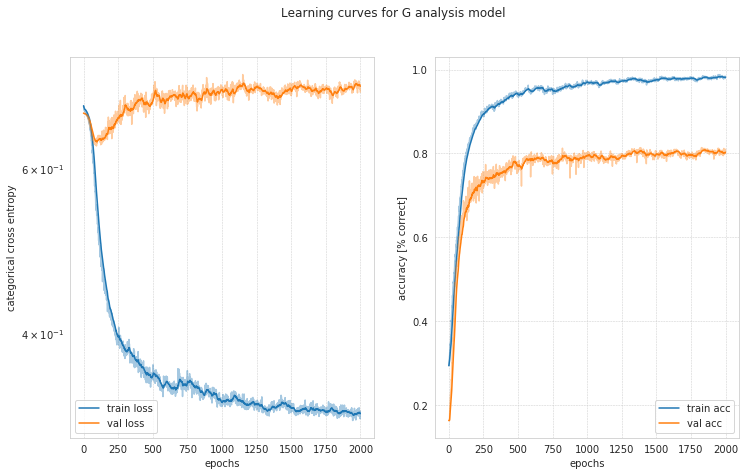

In [156]:
shadow_modelG = denseG(flattened_size)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.05
epochs = 2000

mt = ModelTrainer(shadow_modelG, loss_fun, optim.SGD(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [157]:
shadow_modelG.eval()
pass

In [158]:
positive_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 1]).detach().cpu().numpy()
negative_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 0]).detach().cpu().numpy()

positive_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 1]).detach().cpu().numpy()
negative_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 0]).detach().cpu().numpy()

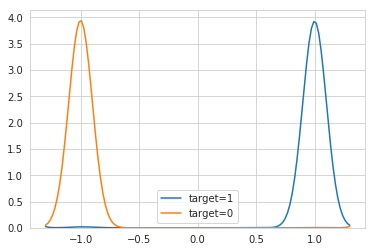

In [159]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_train[:, 1]-positive_train[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_train[:, 1]-negative_train[:, 0], bw=0.1, ax=g, label='target=0')

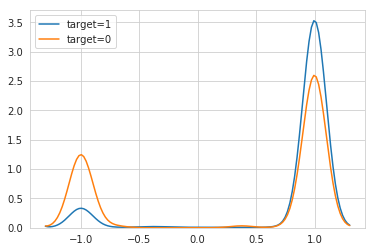

In [160]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_test[:, 1]-positive_test[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_test[:, 1]-negative_test[:, 0], bw=0.1, ax=g, label='target=0')

In [161]:
print("false negative percentage :", 100 - 100*positive_test.argmax(1).sum()/positive_test.shape[0])
print("false positive percentage :", 100*negative_test.argmax(1).sum()/negative_test.shape[0])

false negative percentage : 9.566639411283731
false positive percentage : 67.36401673640168


## 3) Train G with shadow models (Conv layers)

In [100]:
for i in range(nb_shadow_models):
    shadow_models[i].eval()

In [101]:
shadow_models[0]

LeoNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (mxp1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (view): View(_, [-1])
  (fc1): Linear(in_features=576, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [102]:
layers = list()
layer_names = list()

for i in range(nb_shadow_models):
    layers.append(shadow_models[i].conv1)
    layer_names.append("shadow_model["+str(i)+"].conv1")

In [103]:
g_shadow_train_datasets, g_shadow_test_datasets = \
generate_dataset_g_per_class_from_shadows(shadow_models, shadow_train_datasets, shadow_test_datasets, layers, layer_names, split=0.8, nb_class=10)

In [104]:
g_shadow_test_datasets[0][1].shape

torch.Size([1462])

In [105]:
choosen_class = 0
g_shadow_train_dataset = g_shadow_train_datasets[choosen_class]
g_shadow_test_dataset = g_shadow_test_datasets[choosen_class]

g_shadow_train_dataset, g_shadow_test_dataset = normalize_data(g_shadow_train_dataset, g_shadow_test_dataset)

In [108]:
size_input_vector = g_shadow_train_dataset[0].shape
print("size of layer vector :", size_input_vector)

size of layer vector : torch.Size([5441, 1, 16, 24, 24])


In [123]:
g_shadow_target_weigths = torch.abs(1-computeClassesWeights(g_shadow_train_dataset[1]))
g_shadow_target_weigths# = torch.Tensor([0.90, 0.1])

tensor([0.8638, 0.1362])

In [124]:
def kindaResnetG(layer_dim):
    dim = layer_dim[2]
    pad = (1, 1, 1)
    pool = 2
    finalVectorSize = layer_dim[2]//pool * layer_dim[3]//pool * layer_dim[4]//pool
    print(finalVectorSize)
    model = nn.Sequential(
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        
        nn.Conv3d(1, 1, kernel_size=3, padding = pad),
        nn.ReLU(),
        nn.BatchNorm3d(1),
        nn.MaxPool3d(pool),

        View([-1]),
        nn.Linear(finalVectorSize, 128),
        nn.ReLU(),
        #nn.Linear(64, 128),
        #nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 2),
        nn.Softmax(1)
    )
    return model


1152
******************************** Train log ************************************
                     train loss       train acc        val loss         val acc
0                    0.69476675           0.517      0.69967031           0.837
10                   0.59509020           0.690      0.66784078           0.558
20                   0.47458540           0.815      0.76642579           0.725
30                   0.42854584           0.864      0.76838052           0.713
40                   0.40820853           0.898      0.78174001           0.737
50                   0.39125167           0.920      0.77337432           0.725
60                   0.38411906           0.928      0.77624750           0.731
70                   0.38296292           0.930      0.78250849           0.731
80                   0.38426020           0.931      0.78282452           0.732
90                   0.38504147           0.933      0.78328705           0.729
100                  0.38145262    

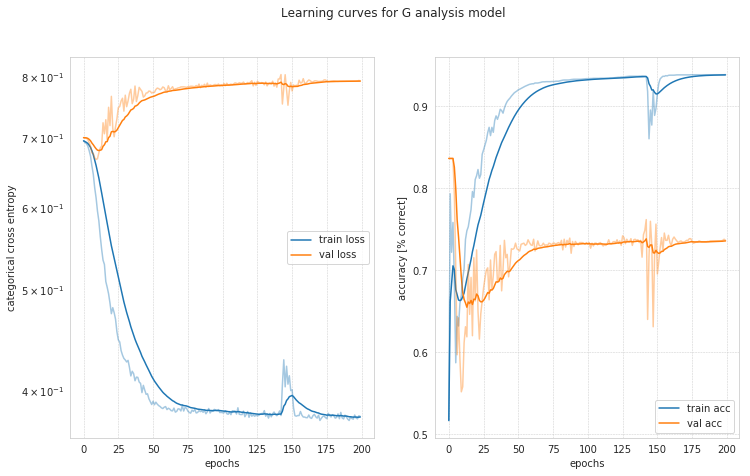

In [126]:
shadow_modelG = kindaResnetG(size_input_vector)

crit_fun = lambda input_, target : (input_, target)
y_hat_fun = lambda y: y.argmax(1)

loss_fun = nn.CrossEntropyLoss(g_shadow_target_weigths)
learning_rate = 0.005
epochs = 200

mt = ModelTrainer(shadow_modelG, loss_fun, optim.Adamax(shadow_modelG.parameters(), lr=learning_rate), y_hat_fun, crit_fun)
hist = mt.fit(g_shadow_train_dataset, g_shadow_test_dataset, epochs=epochs, batch_size=1000, verbose=epochs/20)
mt.plot_training("Learning curves for G analysis model")

In [127]:
shadow_modelG.eval()
pass

In [128]:
positive_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 1]).detach().cpu().numpy()
negative_train = shadow_modelG(g_shadow_train_dataset[0][g_shadow_train_dataset[1] == 0]).detach().cpu().numpy()

positive_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 1]).detach().cpu().numpy()
negative_test = shadow_modelG(g_shadow_test_dataset[0][g_shadow_test_dataset[1] == 0]).detach().cpu().numpy()

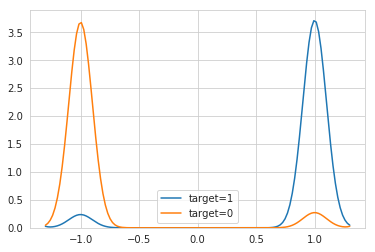

In [129]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_train[:, 1]-positive_train[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_train[:, 1]-negative_train[:, 0], bw=0.1, ax=g, label='target=0')

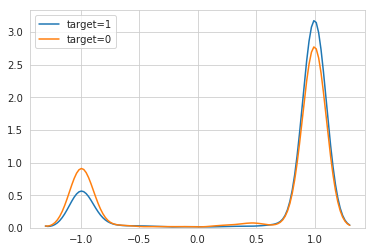

In [130]:
sns.set_style('whitegrid')
g = sns.kdeplot(positive_test[:, 1]-positive_test[:, 0], bw=0.1, label='target=1')
sns.kdeplot(negative_test[:, 1]-negative_test[:, 0], bw=0.1, ax=g, label='target=0')

In [131]:
print("false negative percentage :", 100 - 100*positive_test.argmax(1).sum()/positive_test.shape[0])
print("false positive percentage :", 100*negative_test.argmax(1).sum()/negative_test.shape[0])

false negative percentage : 16.925592804578898
false positive percentage : 74.47698744769875
